In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:.2f}'.format

print("✅ Libraries loaded")

✅ Libraries loaded


### Step 1: Load and Understand the Data

In [2]:
# Load RFM data
rfm = pd.read_csv("../data/processed/rfm_scores.csv")

print(f"📊 Dataset Overview:")
print(f"   Total customers: {len(rfm):,}")
print(f"   Features: {list(rfm.columns)}")
print(f"\n✅ We'll use these 3 features for clustering:")
print(f"   1. Recency (days since last purchase)")
print(f"   2. Frequency (number of purchases)")
print(f"   3. Monetary (total amount spent)")

# Show sample
print(f"\nSample data:")
rfm[['CustomerID', 'recency_days', 'frequency', 'monetary']].head()

📊 Dataset Overview:
   Total customers: 839,081
   Features: ['CustomerID', 'recency_days', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score', 'segment']

✅ We'll use these 3 features for clustering:
   1. Recency (days since last purchase)
   2. Frequency (number of purchases)
   3. Monetary (total amount spent)

Sample data:


,CustomerID,recency_days,frequency,monetary
0,C1010011,26,2,5106.00
1,C1010012,69,1,1499.00
2,C1010014,76,2,1455.00
3,C1010018,37,1,30.00
4,C1010024,65,1,5000.00


In [3]:
print(f"Dataset shape: {rfm.shape}")


Dataset shape: (839081, 9)


### step 2
# Select features for clustering
features = rfm[['recency_days', 'frequency', 'monetary']].copy()

print("Before log transformation:")
print(features.describe())

# Apply log transformation (add 1 to avoid log(0))
features_log = np.log1p(features)

print("\nAfter log transformation:")
print(features_log.describe())

# Standardize (scale) the log-transformed features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_log)

# Convert back to DataFrame for viewing
features_scaled_df = pd.DataFrame(
    features_scaled,
    columns=['recency_log_scaled', 'frequency_log_scaled', 'monetary_log_scaled']
)

print("\nAfter log transformation + scaling:")
print(features_scaled_df.describe())

print("\n✅ Now all features have:")
print("   Mean ≈ 0")
print("   Standard deviation ≈ 1")
print("   Log transformation helps reduce skewness and outliers!")


In [5]:
print(f"Dataset shape: {rfm.shape}")


Dataset shape: (839081, 9)


### Step 3: Find the Optimal Number of Clusters
The Big Question: How many groups should we create?

We'll use 3 different methods to decide:

Elbow Method — Plot inertia (tightness of clusters) and look for the "elbow"
Silhouette Score — Measures how well customers fit in their cluster (higher = better)
Davies-Bouldin Score — Measures cluster separation (lower = better)
Let's test 2 to 15 clusters and see what works best!


In [6]:
# Test different numbers of clusters
K_range = range(2, 16)
inertias = []
silhouette_scores_list = []
davies_bouldin_scores = []

print("Testing different numbers of clusters...\n")
print(f"{'K':>3} | {'Inertia':>15} | {'Silhouette':>12} | {'Davies-Bouldin':>15}")
print("-" * 55)

for k in K_range:
    # Create clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(features_scaled)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(features_scaled, labels, sample_size=10000)
    davies_bouldin = davies_bouldin_score(features_scaled, labels)
    
    # Store results
    inertias.append(inertia)
    silhouette_scores_list.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    
    # Print
    print(f"{k:>3} | {inertia:>15,.0f} | {silhouette:>12.4f} | {davies_bouldin:>15.4f}")

print("\n✅ Testing complete!")

Testing different numbers of clusters...

  K |         Inertia |   Silhouette |  Davies-Bouldin
-------------------------------------------------------
  2 |       1,630,359 |       0.5344 |          0.8624
  3 |       1,201,842 |       0.3447 |          1.0286
  4 |         912,350 |       0.3620 |          0.8197
  5 |         700,987 |       0.3745 |          0.7470
  6 |         581,838 |       0.3667 |          0.7280
  7 |         515,773 |       0.3632 |          0.7577
  8 |         464,553 |       0.3646 |          0.8209
  9 |         424,141 |       0.3260 |          0.9783
 10 |         383,341 |       0.3370 |          0.9122
 11 |         347,210 |       0.3504 |          0.8668
 12 |         314,867 |       0.3497 |          0.8558
 13 |         287,509 |       0.3464 |          0.8144
 14 |         267,894 |       0.3426 |          0.8250
 15 |         253,793 |       0.3411 |          0.8394

✅ Testing complete!


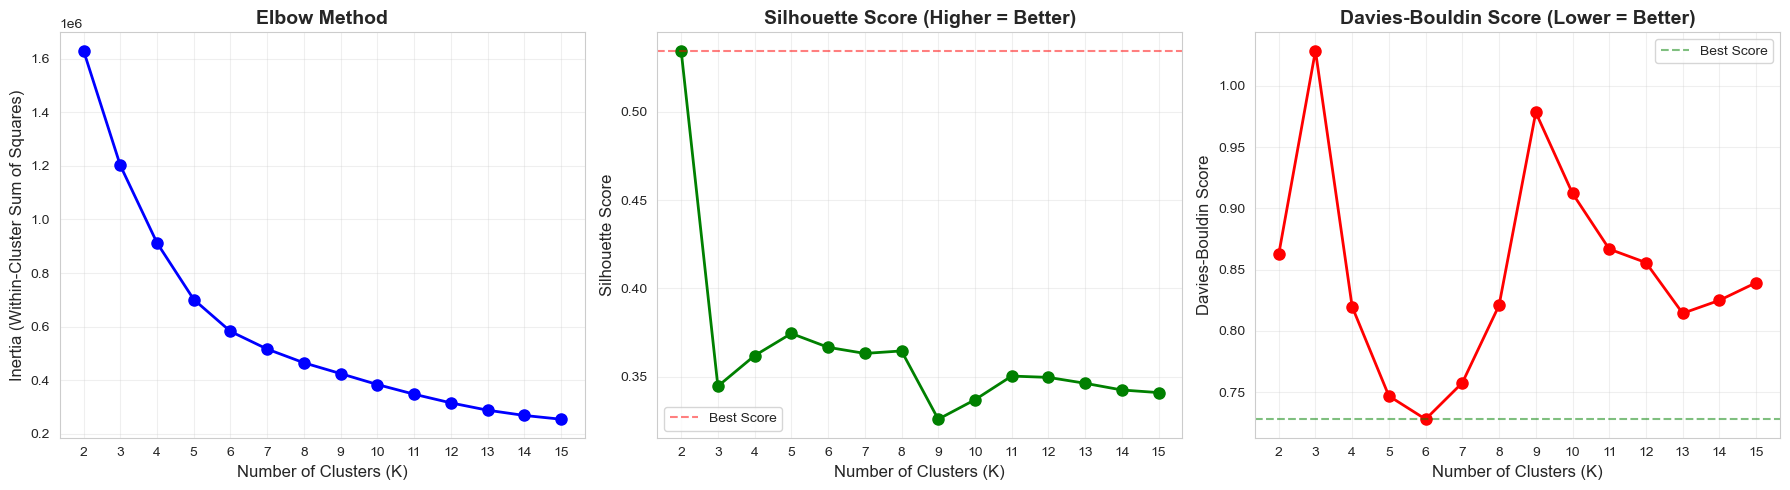

In [7]:
# Visualize all three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Elbow Method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(K_range)

# 2. Silhouette Score (higher = better)
axes[1].plot(K_range, silhouette_scores_list, 'go-', linewidth=2, markersize=8)
axes[1].axhline(y=max(silhouette_scores_list), color='red', linestyle='--', alpha=0.5, label='Best Score')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(K_range)
axes[1].legend()

# 3. Davies-Bouldin Score (lower = better)
axes[2].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].axhline(y=min(davies_bouldin_scores), color='green', linestyle='--', alpha=0.5, label='Best Score')
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[2].set_title('Davies-Bouldin Score (Lower = Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(K_range)
axes[2].legend()

plt.tight_layout()
plt.show()

In [8]:
# Determine optimal K
best_k_silhouette = K_range[silhouette_scores_list.index(max(silhouette_scores_list))]
best_k_davies = K_range[davies_bouldin_scores.index(min(davies_bouldin_scores))]

print("📊 RECOMMENDATIONS:\n")
print(f"Based on Silhouette Score: K = {best_k_silhouette} (score: {max(silhouette_scores_list):.4f})")
print(f"Based on Davies-Bouldin: K = {best_k_davies} (score: {min(davies_bouldin_scores):.4f})")
print(f"\nElbow Method: Look for the 'elbow' in the first chart (where the curve bends)")

# Choose the optimal k
optimal_k = best_k_davies  # Using Davies-Bouldin for better business granularity

print(f"\n🎯 FINAL CHOICE: K = {optimal_k}")
print(f"   This provides better business granularity for actionable segments")

📊 RECOMMENDATIONS:

Based on Silhouette Score: K = 2 (score: 0.5344)
Based on Davies-Bouldin: K = 6 (score: 0.7280)

Elbow Method: Look for the 'elbow' in the first chart (where the curve bends)

🎯 FINAL CHOICE: K = 6
   This provides better business granularity for actionable segments


### Step 4: Create Final Clusters
Now that we know the optimal number of clusters, let's create them!

In [10]:
# Create final clustering model
final_kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=20,        # Try 20 different starting points
    max_iter=500,     # Allow up to 500 iterations
    algorithm='lloyd'  # Use standard KMeans algorithm
)

# Fit and predict
cluster_labels = final_kmeans.fit_predict(features_scaled)
rfm['Cluster'] = cluster_labels

print(f"✅ Created {optimal_k} clusters!")
print(f"\nCluster distribution:")
print(rfm['Cluster'].value_counts().sort_index())

# Calculate final quality metrics
final_silhouette = silhouette_score(features_scaled, cluster_labels, sample_size=10000)
final_davies_bouldin = davies_bouldin_score(features_scaled, cluster_labels)
final_calinski = calinski_harabasz_score(features_scaled, cluster_labels)

print(f"\n📊 Final Cluster Quality:")
print(f"   Silhouette Score: {final_silhouette:.4f} (higher = better, max = 1)")
print(f"   Davies-Bouldin Score: {final_davies_bouldin:.4f} (lower = better)")
print(f"   Calinski-Harabasz Score: {final_calinski:,.2f} (higher = better)")

✅ Created 6 clusters!

Cluster distribution:
Cluster
0    187402
1    128986
2    127803
3    234424
4      3406
5    157060
Name: count, dtype: int64

📊 Final Cluster Quality:
   Silhouette Score: 0.3686 (higher = better, max = 1)
   Davies-Bouldin Score: 0.7280 (lower = better)
   Calinski-Harabasz Score: 558,218.72 (higher = better)


### Step 5: Profile Each Cluster
Let's understand what makes each cluster unique!

In [11]:
# Create detailed cluster profiles
cluster_profiles = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'recency_days': ['mean', 'median', 'std'],
    'frequency': ['mean', 'median', 'std'],
    'monetary': ['mean', 'median', 'std']
}).round(2)

# Flatten column names
cluster_profiles.columns = ['_'.join(col).strip() for col in cluster_profiles.columns.values]
cluster_profiles.columns = [
    'Customers', 
    'Recency_Mean', 'Recency_Median', 'Recency_Std',
    'Frequency_Mean', 'Frequency_Median', 'Frequency_Std',
    'Monetary_Mean', 'Monetary_Median', 'Monetary_Std'
]

# Add percentage of total customers
cluster_profiles['Percentage'] = (cluster_profiles['Customers'] / len(rfm) * 100).round(1)

# Sort by size
cluster_profiles = cluster_profiles.sort_values('Customers', ascending=False)

print("📊 CLUSTER PROFILES:\n")
print(cluster_profiles[['Customers', 'Percentage', 'Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']])

📊 CLUSTER PROFILES:

         Customers  Percentage  Recency_Mean  Frequency_Mean  Monetary_Mean
Cluster                                                                    
3           234424       27.90         69.32            1.00         432.59
0           187402       22.30         41.07            1.00         693.36
5           157060       18.70         61.61            1.00        5034.99
1           128986       15.40         57.69            1.00          52.84
2           127803       15.20         49.00            2.13        3083.27
4             3406        0.40          1.00            1.35        2377.61


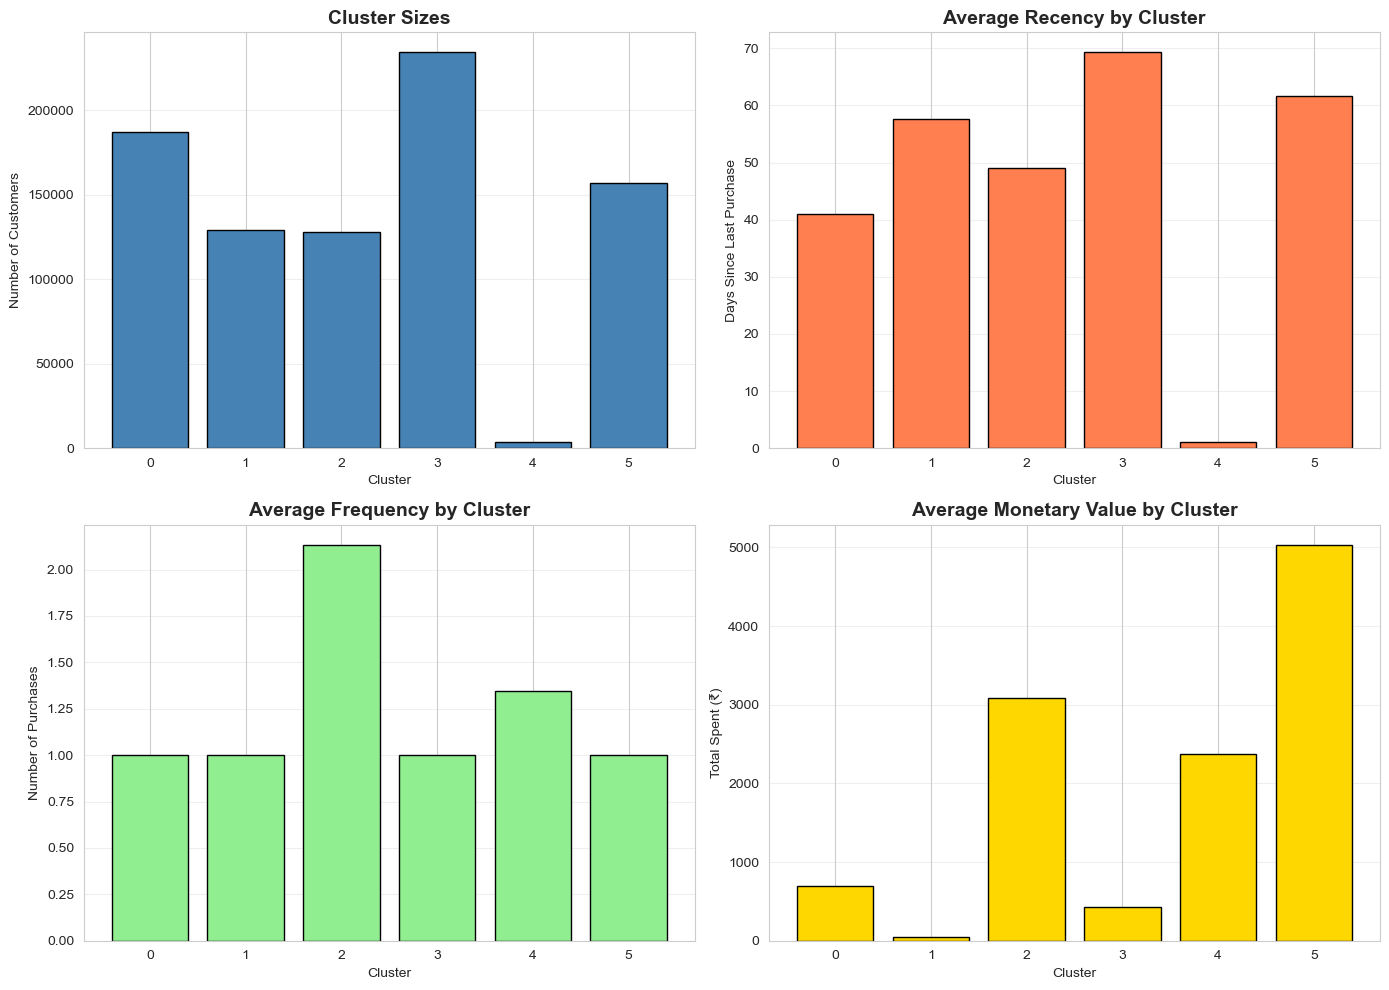

In [12]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Cluster sizes
cluster_sizes = rfm['Cluster'].value_counts().sort_index()
axes[0, 0].bar(cluster_sizes.index, cluster_sizes.values, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Cluster Sizes', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Average Recency by Cluster
recency_by_cluster = rfm.groupby('Cluster')['recency_days'].mean().sort_index()
axes[0, 1].bar(recency_by_cluster.index, recency_by_cluster.values, color='coral', edgecolor='black')
axes[0, 1].set_title('Average Recency by Cluster', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Days Since Last Purchase')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Average Frequency by Cluster
frequency_by_cluster = rfm.groupby('Cluster')['frequency'].mean().sort_index()
axes[1, 0].bar(frequency_by_cluster.index, frequency_by_cluster.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Average Frequency by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Purchases')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average Monetary by Cluster
monetary_by_cluster = rfm.groupby('Cluster')['monetary'].mean().sort_index()
axes[1, 1].bar(monetary_by_cluster.index, monetary_by_cluster.values, color='gold', edgecolor='black')
axes[1, 1].set_title('Average Monetary Value by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Total Spent (₹)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Step 6: Give Clusters Business-Friendly Names
Numbers (0, 1, 2...) don't mean much to business teams. Let's give each cluster a meaningful name based on its characteristics!

In [15]:
# Adjusted cluster naming function for 6 clusters
def assign_cluster_name(cluster_num):
    """
    Assign business-friendly name based on RFM characteristics.
    Ensures unique, non-overlapping names for 6 clusters.
    """
    profile = cluster_profiles.loc[cluster_num]
    
    recency = profile['Recency_Mean']
    frequency = profile['Frequency_Mean']
    monetary = profile['Monetary_Mean']
    
    # Decision logic for 6 clusters

    if recency < 35 and frequency > 3 and monetary > 3500:
        return "Champions"          # Recent, frequent, high spend
    elif monetary > 4500:
        return "Big Spenders"       # High monetary, may not be frequent
    elif recency < 55 and frequency > 2:
        return "Loyal Customers"    # Regular buyers
    elif recency < 75 and frequency < 2 and monetary > 500:
        return "Potential Loyalists" # Moderate spend, could become loyal
    elif recency > 65 and frequency < 1.5 and monetary < 1000:
        return "At Risk"            # Not bought recently, low spend
    else:
        return "Standard Customers"  # Everything else (average behavior) # Decision logic for 6 clusters
   

# Map cluster numbers to names
cluster_names = {cluster: assign_cluster_name(cluster) for cluster in cluster_profiles.index}

# Print cluster names with sizes
print("🏷️ CLUSTER NAMES:\n")
for cluster_num, name in cluster_names.items():
    size = cluster_profiles.loc[cluster_num, 'Customers']
    pct = cluster_profiles.loc[cluster_num, 'Percentage']
    print(f"   Cluster {cluster_num} → {name:20s} ({size:>7,} customers, {pct:>5.1f}%)")

# Apply names to the main dataframe
rfm['Segment_Name'] = rfm['Cluster'].map(cluster_names)
 
print("\n✅ Named all clusters!")


🏷️ CLUSTER NAMES:

   Cluster 3 → At Risk              (234,424 customers,  27.9%)
   Cluster 0 → Potential Loyalists  (187,402 customers,  22.3%)
   Cluster 5 → Big Spenders         (157,060 customers,  18.7%)
   Cluster 1 → Standard Customers   (128,986 customers,  15.4%)
   Cluster 2 → Loyal Customers      (127,803 customers,  15.2%)
   Cluster 4 → Potential Loyalists  (  3,406 customers,   0.4%)

✅ Named all clusters!


### Step 7: Visualize Clusters in 3D Space
Let's see how the clusters look in the RFM space!

C:\Users\asant\AppData\Local\Temp\ipykernel_12984\1094402394.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors_map = plt.cm.get_cmap('tab10', optimal_k)


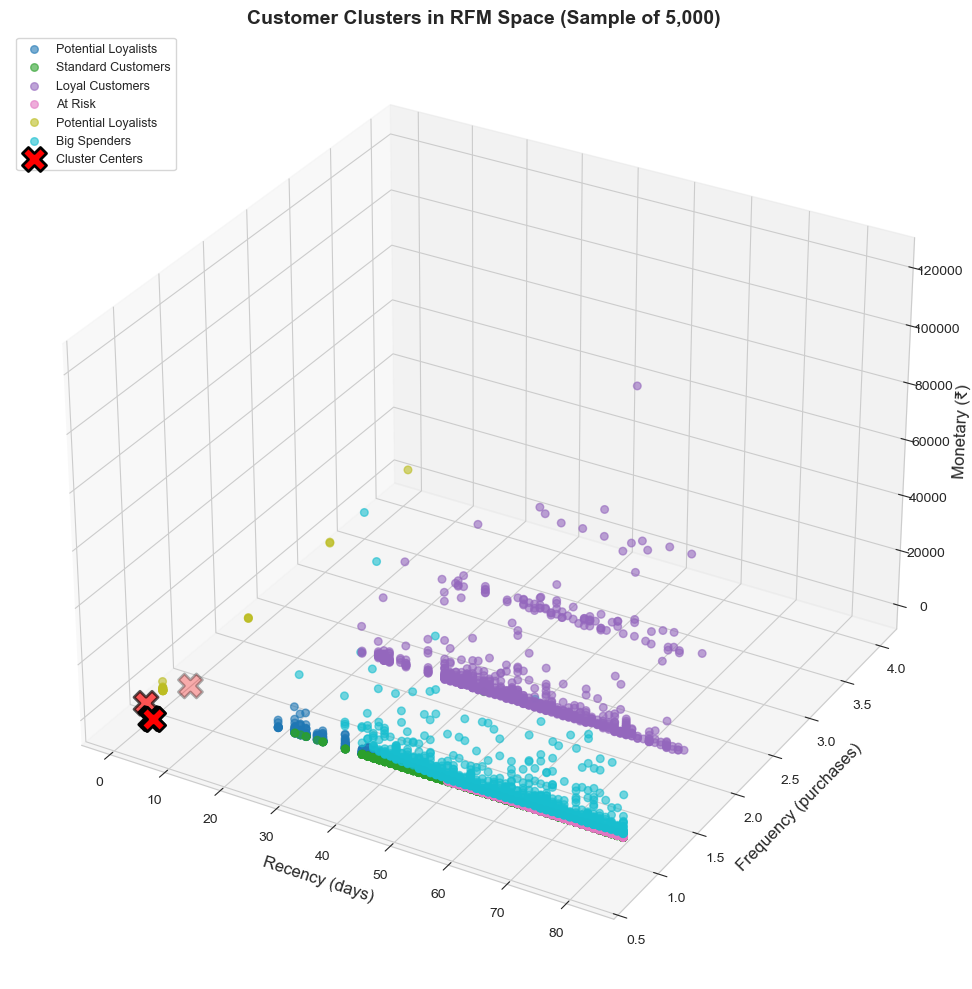

📊 The 3D plot shows how clusters are separated in RFM space


In [17]:
# 3D Scatter plot (sample for performance)
from mpl_toolkits.mplot3d import Axes3D

# Sample 5000 customers for visualization
sample = rfm.sample(n=5000, random_state=42)

fig = plt.figure(figsize=(14, 10))

# Create 3D plot
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with different color
colors_map = plt.cm.get_cmap('tab10', optimal_k)
for cluster_num in range(optimal_k):
    cluster_data = sample[sample['Cluster'] == cluster_num]
    ax.scatter(
        cluster_data['recency_days'],
        cluster_data['frequency'],
        cluster_data['monetary'],
        c=[colors_map(cluster_num)],
        label=f"{cluster_names[cluster_num]}",
        alpha=0.6,
        s=30
    )

# Plot cluster centers
centers = final_kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers)  # Convert back to original scale
ax.scatter(
    centers_original[:, 0],
    centers_original[:, 1],
    centers_original[:, 2],
    c='red',
    marker='X',
    s=300,
    edgecolors='black',
    linewidths=2,
    label='Cluster Centers'
)

ax.set_xlabel('Recency (days)', fontsize=12)
ax.set_ylabel('Frequency (purchases)', fontsize=12)
ax.set_zlabel('Monetary (₹)', fontsize=12)
ax.set_title('Customer Clusters in RFM Space (Sample of 5,000)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

print("📊 The 3D plot shows how clusters are separated in RFM space")

### Step 8: Business Interpretation & Recommendations
Now let's translate these clusters into actionable business strategies!

In [18]:
# Create business summary
business_summary = rfm.groupby('Segment_Name').agg({
    'CustomerID': 'count',
    'recency_days': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum']
}).round(2)

business_summary.columns = ['Customers', 'Avg_Recency', 'Avg_Frequency', 'Avg_Spent', 'Total_Revenue']
business_summary['Revenue_%'] = (business_summary['Total_Revenue'] / business_summary['Total_Revenue'].sum() * 100).round(1)
business_summary = business_summary.sort_values('Total_Revenue', ascending=False)

print("💼 BUSINESS SUMMARY BY SEGMENT:\n")
print(business_summary)

print("\n" + "="*80)
print("📌 KEY INSIGHTS:")
print("="*80)

# Find top revenue segments
top_revenue_segments = business_summary.nlargest(3, 'Total_Revenue')
print(f"\n🏆 Top 3 Revenue-Generating Segments:")
for segment in top_revenue_segments.index:
    revenue_pct = top_revenue_segments.loc[segment, 'Revenue_%']
    customers = top_revenue_segments.loc[segment, 'Customers']
    print(f"   {segment}: {revenue_pct}% of revenue ({customers:,} customers)")

💼 BUSINESS SUMMARY BY SEGMENT:

                     Customers  Avg_Recency  Avg_Frequency  Avg_Spent  \
Segment_Name                                                            
Big Spenders            157060        61.61           1.00    5034.99   
Loyal Customers         127803        49.00           2.13    3083.27   
Potential Loyalists     190808        40.35           1.01     723.43   
At Risk                 234424        69.32           1.00     432.59   
Standard Customers      128986        57.69           1.00      52.84   

                     Total_Revenue  Revenue_%  
Segment_Name                                   
Big Spenders          790794755.32      55.30  
Loyal Customers       394050731.12      27.50  
Potential Loyalists   138035451.10       9.60  
At Risk               101409508.12       7.10  
Standard Customers      6816006.60       0.50  

📌 KEY INSIGHTS:

🏆 Top 3 Revenue-Generating Segments:
   Big Spenders: 55.3% of revenue (157,060 customers)
   Loyal Cu

In [19]:
# Marketing recommendations for each segment
recommendations = {
    "Champions": "🏆 VIP treatment, early access to products, exclusive events",
    "High Value": "💎 Premium services, personalized offers, account manager",
    "Loyal Customers": "❤️ Loyalty rewards, referral bonuses, appreciation campaigns",
    "Active Customers": "✅ Engagement campaigns, product recommendations, upselling",
    "Frequent Buyers": "🔄 Subscription models, bulk discounts, convenience features",
    "Standard Customers": "📊 A/B test campaigns, identify growth opportunities",
    "At Risk": "⚠️ Win-back offers, surveys to understand issues, re-engagement",
    "Dormant": "💤 Final win-back attempt or archive, minimal marketing spend"
}

print("\n" + "="*80)
print("🎯 MARKETING RECOMMENDATIONS:")
print("="*80 + "\n")

for segment in business_summary.index:
    customers = business_summary.loc[segment, 'Customers']
    revenue_pct = business_summary.loc[segment, 'Revenue_%']
    recommendation = recommendations.get(segment, "🔍 Analyze further and develop custom strategy")
    
    print(f"{segment}:")
    print(f"  Size: {customers:,} customers ({revenue_pct}% of revenue)")
    print(f"  Action: {recommendation}")
    print()


🎯 MARKETING RECOMMENDATIONS:

Big Spenders:
  Size: 157,060 customers (55.3% of revenue)
  Action: 🔍 Analyze further and develop custom strategy

Loyal Customers:
  Size: 127,803 customers (27.5% of revenue)
  Action: ❤️ Loyalty rewards, referral bonuses, appreciation campaigns

Potential Loyalists:
  Size: 190,808 customers (9.6% of revenue)
  Action: 🔍 Analyze further and develop custom strategy

At Risk:
  Size: 234,424 customers (7.1% of revenue)
  Action: ⚠️ Win-back offers, surveys to understand issues, re-engagement

Standard Customers:
  Size: 128,986 customers (0.5% of revenue)
  Action: 📊 A/B test campaigns, identify growth opportunities



### Step 9: Save Results


In [20]:
# Save clustered data
output = rfm[['CustomerID', 'recency_days', 'frequency', 'monetary', 
              'R_score', 'F_score', 'M_score', 'Cluster', 'Segment_Name']]

output.to_csv("../data/processed/kmeans_customer_segments.csv", index=False)
print(f"✅ Saved: kmeans_customer_segments.csv ({len(output):,} customers)")

# Save cluster profiles
cluster_profiles.to_csv("../data/processed/cluster_profiles.csv")
print(f"✅ Saved: cluster_profiles.csv ({len(cluster_profiles)} clusters)")

# Save model summary
model_summary = pd.DataFrame({
    'Metric': [
        'Algorithm',
        'Number of Clusters',
        'Total Customers',
        'Silhouette Score',
        'Davies-Bouldin Score',
        'Calinski-Harabasz Score',
        'Best Segment (by revenue)'
    ],
    'Value': [
        'KMeans',
        optimal_k,
        len(rfm),
        f"{final_silhouette:.4f}",
        f"{final_davies_bouldin:.4f}",
        f"{final_calinski:,.2f}",
        business_summary.index[0]
    ]
})

model_summary.to_csv("../data/processed/kmeans_model_summary.csv", index=False)
print(f"✅ Saved: kmeans_model_summary.csv")

print("\n" + model_summary.to_string(index=False))

✅ Saved: kmeans_customer_segments.csv (839,081 customers)
✅ Saved: cluster_profiles.csv (6 clusters)
✅ Saved: kmeans_model_summary.csv

                   Metric        Value
                Algorithm       KMeans
       Number of Clusters            6
          Total Customers       839081
         Silhouette Score       0.3686
     Davies-Bouldin Score       0.7280
  Calinski-Harabasz Score   558,218.72
Best Segment (by revenue) Big Spenders


In [21]:
model_summary.head()

,Metric,Value
0,Algorithm,KMeans
1,Number of Clusters,6
2,Total Customers,839081
3,Silhouette Score,0.3686
4,Davies-Bouldin Score,0.7280


In [24]:
output.head()

,CustomerID,recency_days,frequency,monetary,R_score,F_score,M_score,Cluster,Segment_Name
0,C1010011,26,2,5106.00,5,5,5,2,Loyal Customers
1,C1010012,69,1,1499.00,2,1,4,5,Big Spenders
2,C1010014,76,2,1455.00,1,5,4,2,Loyal Customers
3,C1010018,37,1,30.00,5,1,1,1,Standard Customers
4,C1010024,65,1,5000.00,2,1,5,5,Big Spenders
